In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm.notebook import tqdm
import torch.nn.functional as F
import GPUtil
import random
%cd colorpoem/prototypes

C:\Users\green\Desktop\workspace\colorpoem\prototypes


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [3]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=8)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [4]:
dataframe = pd.read_csv('../resource/emotion_classification.csv').dropna(axis=0)#.sample(frac=0.2)
#중립0 행복1 슬픔2 공포3 분노4 놀람5 혐오6 상처7
emodict = {'중립':0, '행복':1, '슬픔':2, '공포':3, '분노':4, '놀람':5, '혐오':6, '상처':7}
for k,v in emodict.items():
    dataframe = dataframe.replace(k, v)
dataframe[:10]

,사람문장1,감정_대분류
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,3
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,5
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,1
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,1
5,이제 곧 은퇴할 시기가 되었어. 내가 먼저 은퇴를 하고 육 개월 후에 남편도 은퇴를...,3
6,사십 대에 접어들면서 머리카락이 많이 빠져 고민이야.,2
7,이제 돈이라면 지긋지긋해.,4
8,친구들이 나를 괴롭혀. 부모님과 선생님께 얘기했는데도 믿어주지 않아.,4
9,친구 때문에 눈물 나.,2


In [5]:
dataframe['감정_대분류'].value_counts()

0    60577
2    28430
4    22794
5    19875
1    18148
3    16912
6    10026
7     7440
Name: 감정_대분류, dtype: int64

<AxesSubplot:>

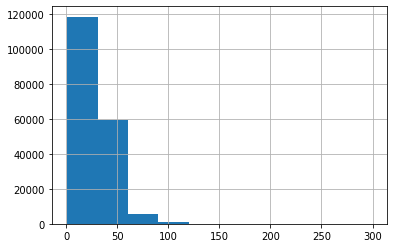

In [6]:
dataframe['사람문장1'].str.len().hist()

In [7]:
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)

In [8]:
max_len = 128
batch_size = 64
learning_rate =  5e-5
epochs = 5
seed_val = 42

In [9]:
# test = []
# for index, row in tqdm(dataframe[:20].iterrows(), total=dataframe.shape[0]):
#     text = row[0]
#     encoded_list = [tokenizer.encode(t, add_special_tokens=True, max_length=max_len, padding='max_length', truncation=True) for t in text]
#     test.append(encoded_list)
# newdf = pd.DataFrame({'사람문장' : test, '감정_대분류' :dataframe['감정_대분류'][:20]}).reset_index(drop=True)
# print(newdf[:5])

In [10]:
class MyDataset(Dataset):
    def __init__(self, df):
        total_list = []
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            text = row[0]
            encoded_list = tokenizer.encode(text, add_special_tokens=True, max_length=max_len, padding='max_length', truncation=True)
            total_list.append(encoded_list)
        self.df = pd.DataFrame({'사람문장' : total_list, '감정_대분류' :df['감정_대분류']}).reset_index(drop=True)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = np.array(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        return text, label

In [11]:
train_dataset = MyDataset(train_df)
test_dataset = MyDataset(test_df)

  0%|          | 0/147361 [00:00<?, ?it/s]

  0%|          | 0/36841 [00:00<?, ?it/s]

In [12]:
def collate_fn(data):
    text, label = data[0], data[1] 
    return torch.tensor(text), torch.tensor(label)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [13]:
next(iter(train_dataloader))

[tensor([[   101,   9708, 119235,  ...,      0,      0,      0],
         [   101,   9303,  11287,  ...,      0,      0,      0],
         [   101,   9011,    117,  ...,      0,      0,      0],
         ...,
         [   101,  58466,   9663,  ...,      0,      0,      0],
         [   101,   9638,  17730,  ...,      0,      0,      0],
         [   101,   9524, 119118,  ...,      0,      0,      0]],
        dtype=torch.int32),
 tensor([0, 5, 0, 4, 2, 5, 4, 2, 1, 0, 3, 0, 0, 2, 0, 5, 0, 6, 5, 4, 0, 2, 0, 5,
         2, 4, 5, 1, 5, 4, 0, 0, 5, 1, 4, 0, 0, 4, 7, 3, 0, 5, 5, 2, 4, 0, 4, 5,
         0, 0, 4, 2, 0, 4, 1, 5, 5, 6, 4, 0, 3, 6, 1, 6])]

In [14]:
device = torch.device("cuda:0")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [15]:
optimizer = Adam(model.parameters(), lr=learning_rate)
p_itr = 500
itr=1

In [16]:
def categorical_accuracy(logits, label):
    top_logits = torch.argmax(F.softmax(logits, dim=1), dim=1)
    correct = top_logits.eq(label).sum()
    return correct

In [17]:
print(train_dataset.__getitem__(0))

(array([   101,   9665,  17655,   9638,  11287,   9519,  46150,  12424,
         9539,  10622,   9266,  11664,  60030,   8989,  36908,   9523,
        16985,    119,  77039,   9519,  28396,  25503,   9637,  49636,
         9312,  32158,  33077,  12605, 118867,  12508,  12092,  45593,
         9715, 119230,  10739,   8982,  77884,    119,    102,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
     

In [18]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

for epoch in range(epochs):
    # GPUtil.showUtilization()
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch_id, (text, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        #encoded_list = [tokenizer.encode(t, add_special_tokens=True, max_length=max_len, padding='max_length', truncation=True) for t in text]
        # print(text)
        # print('-------------')
        sample = text.to(device)
        label = label.to(device)
        outputs = model(sample, labels=label)
        
        loss = outputs[0]
        logits = outputs[1]
        # print(logits)
        loss.backward()
        optimizer.step()

        acc = categorical_accuracy(logits, label) 
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        if itr % p_itr == 0:
            print('[Epoch {}/{}] itr {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, epoch_loss/(batch_id+1), epoch_acc/((1+batch_id)*batch_size)))
        #torch.save(model.state_dict(), './model.pt')
        itr+=1 
     
    model.eval()
    test_acc = 0
    for batch_id, (text, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        sample = text.to(device)
        label = label.to(device)
        with torch.no_grad():    
            outputs = model(sample, labels=label)
        logits = outputs[1]
        acc = categorical_accuracy(logits, label)
        test_acc += acc.item()
    print("epoch {} test acc {}".format(epoch+1, test_acc/(batch_size*(batch_id+1))))

  0%|          | 0/2303 [00:00<?, ?it/s]

[Epoch 1/5] itr 500 -> Train Loss: 1.5740, Accuracy: 0.438
[Epoch 1/5] itr 1000 -> Train Loss: 1.4159, Accuracy: 0.499
[Epoch 1/5] itr 1500 -> Train Loss: 1.3421, Accuracy: 0.525
[Epoch 1/5] itr 2000 -> Train Loss: 1.2980, Accuracy: 0.541


  0%|          | 0/576 [00:00<?, ?it/s]

epoch 1 test acc 0.5973578559027778


  0%|          | 0/2303 [00:00<?, ?it/s]

[Epoch 2/5] itr 2500 -> Train Loss: 1.0713, Accuracy: 0.626
[Epoch 2/5] itr 3000 -> Train Loss: 1.0662, Accuracy: 0.624
[Epoch 2/5] itr 3500 -> Train Loss: 1.0637, Accuracy: 0.623


KeyboardInterrupt: 

In [ ]:
def predict(sentence):
    df = pd.DataFrame({'사람문장':[sentence], '감정_대분류':[0]})
    #print(df)
    dataset = MyDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    model.eval()
    for batch_id, (text, label) in tqdm(enumerate(dataloader), total=len(dataloader)): 
        sample = text.to(device)
        with torch.no_grad():    
            outputs = model(sample)
        logits = outputs[0]
        return [k for k, v in emodict.items() if v == torch.argmax(logits)][0]

In [ ]:
predict("너는 누구에게 한번이라도 뜨거운 사람이었느냐")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

'중립'

##### 